# 🇧🇷 Análise de Feedback Global (NLP) - Análise de Sentimento Multilíngue # 🇬🇧 Global Customer Feedback (NLP) - Multilingual Sentiment Analysis # 🇪🇸 Análisis de Feedback Global (NLP) - Análisis de Sentimiento Multilingüe # 🇩🇪 Globale Kundenfeedback-Analyse (NLP) - Mehrsprachige Stimmungsanalyse

--- **PT:** Este projeto analisa reviews de clientes em 4 idiomas para identificar o sentimento geral e os principais pontos problemáticos (reclamações). **EN:** This project analyzes customer reviews in 4 languages to identify overall sentiment and key pain points. **ES:** Este proyecto analiza reseñas de clientes en 4 idiomas para identificar el sentimiento general y los principales puntos problemáticos. **DE:** Dieses Projekt analysiert Kundenbewertungen in 4 Sprachen, um die allgemeine Stimmung und die wichtigsten Kritikpunkte zu identifizieren.

In [7]:
# Instalar as bibliotecas de NLP necessárias
!pip install nltk
!pip install vaderSentiment
!pip install wordcloud
# Usamos uma versão específica do googletrans que funciona no Colab
!pip install googletrans==4.0.0-rc1

# Libs de Análise e NLP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from googletrans import Translator

# Libs do Colab
from google.colab import files
import io

# Baixar recursos do NLTK (para stopwords)
nltk.download('stopwords')

print("PT: Bibliotecas de NLP carregadas!")
print("EN: NLP libraries loaded!")

PT: Bibliotecas de NLP carregadas!
EN: NLP libraries loaded!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
print("PT: Faça o upload do arquivo 'customer_reviews_multilingual.csv'")
print("EN: Please upload the file 'customer_reviews_multilingual.csv'")

uploaded = files.upload()

# --- INÍCIO DA CORREÇÃO ---
# Pega o nome do primeiro arquivo que foi feito upload (não importa se é (1).csv, (2).csv, etc.)
nome_do_arquivo = list(uploaded.keys())[0]
print(f"Arquivo '{nome_do_arquivo}' carregado.")

# Lê o arquivo usando o nome que encontramos
df = pd.read_csv(io.BytesIO(uploaded[nome_do_arquivo]))
# --- FIM DA CORREÇÃO ---

print("\nPT: Arquivo carregado com sucesso!")
print("EN: File loaded successfully!")
display(df.head())

PT: Faça o upload do arquivo 'customer_reviews_multilingual.csv'
EN: Please upload the file 'customer_reviews_multilingual.csv'


Saving customer_reviews_multilingual.csv to customer_reviews_multilingual (3).csv
Arquivo 'customer_reviews_multilingual (3).csv' carregado.

PT: Arquivo carregado com sucesso!
EN: File loaded successfully!


,review_id,review_text,language,rating
0,101,This app is amazing! Love the new features.,EN,5
1,102,It crashes every time I open it. Useless.,EN,1
2,103,"Good, but the price is too high.",EN,3
3,104,The new update is very slow.,EN,2
4,105,Best app for productivity!,EN,5


# 2. Análise Exploratória (EDA) # 2. Exploratory Data Analysis (EDA)

**PT:** Vamos ver a distribuição das avaliações e idiomas. **EN:** Let's check the distribution of ratings and languages. **ES:** Veamos la distribución de valoraciones e idiomas. **DE:** Überprüfen wir die Verteilung von Bewertungen und Sprachen.

/tmp/ipython-input-843588011.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='language', palette='viridis')


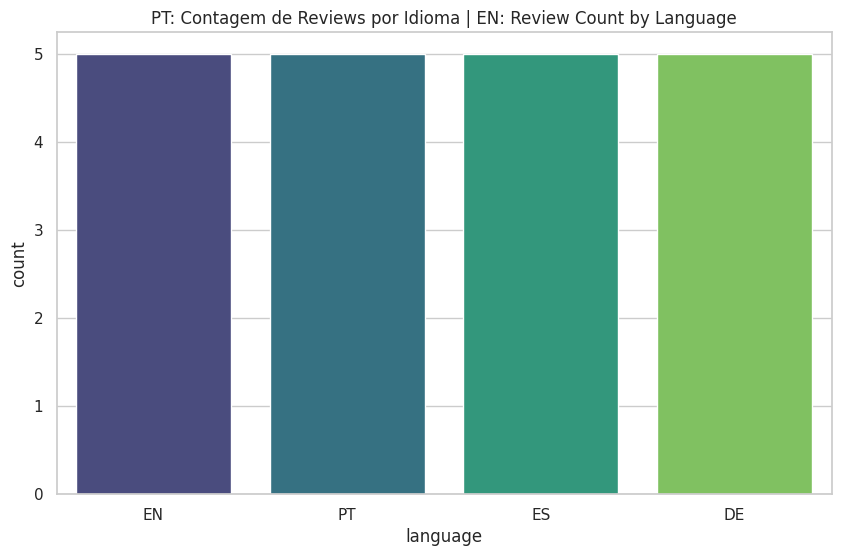

/tmp/ipython-input-843588011.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=media_rating, x='language', y='rating', palette='plasma')


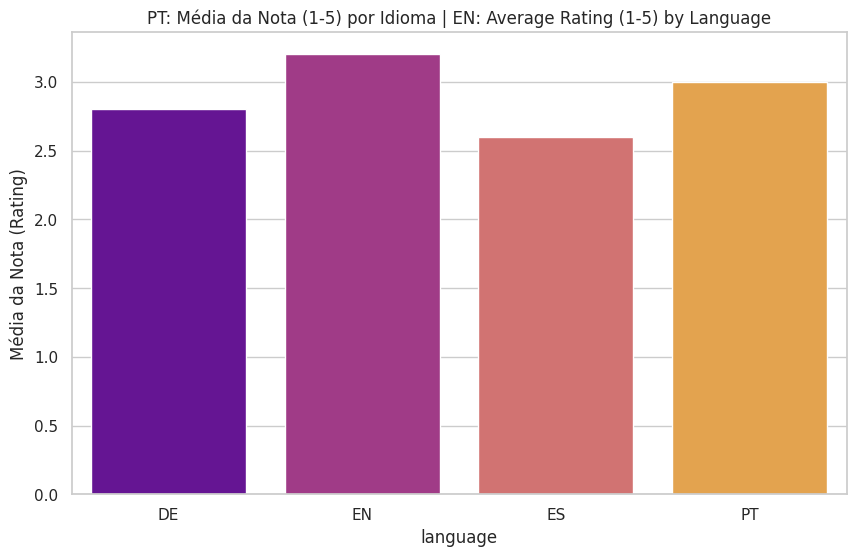

In [11]:
sns.set(style="whitegrid")

# Gráfico 1: Contagem por Idioma
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='language', palette='viridis')
plt.title('PT: Contagem de Reviews por Idioma | EN: Review Count by Language')
plt.show()

# Gráfico 2: Média de Nota (Rating) por Idioma
media_rating = df.groupby('language')['rating'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=media_rating, x='language', y='rating', palette='plasma')
plt.title('PT: Média da Nota (1-5) por Idioma | EN: Average Rating (1-5) by Language')
plt.ylabel('Média da Nota (Rating)')
plt.show()
# Insight: O mercado Alemão (DE) parece ser o mais insatisfeito!

# 3. Pré-processamento e Tradução (O Desafio Multilíngue) # 3. Pre-processing and Translation (The Multilingual Challenge)

**PT:** Modelos de Sentimento (como o VADER) funcionam melhor em um único idioma (Inglês). Vamos traduzir tudo para Inglês primeiro. **EN:** Sentiment models (like VADER) work best on a single language (English). We will translate everything to English first. **ES:** Los modelos de sentimiento (como VADER) funcionan mejor en un solo idioma (inglés). Traduciremos todo al inglés primero. **DE:** Sentiment-Modelle (wie VADER) funktionieren am besten in einer einzigen Sprache (Englisch). Wir werden zuerst alles ins Englische übersetzen.

In [12]:
# Inicializar o tradutor
translator = Translator()

# Função para limpar e traduzir
def processar_review(row):
    texto = str(row['review_text'])
    idioma = row['language']

    # 1. Limpar o texto (remover pontuação e deixar minúsculo)
    texto_limpo = re.sub(r'[^\w\s]', '', texto).lower()

    # 2. Traduzir (apenas se não for inglês)
    if idioma == 'EN':
        return texto_limpo
    else:
        try:
            # A API do Google pode ser instável, por isso o 'try...except'
            traducao = translator.translate(texto_limpo, src=idioma, dest='en')
            return traducao.text
        except Exception as e:
            print(f"Erro ao traduzir: {e}")
            return None # Retorna Nulo se a API falhar

print("PT: Iniciando tradução... (Isso pode levar alguns segundos)")
print("EN: Starting translation... (This may take a few seconds)")

# Aplicar a função para criar a nova coluna
df['review_EN_traduzido'] = df.apply(processar_review, axis=1)

print("\nPT: Tradução concluída!")
print("EN: Translation complete!")
display(df[['language', 'review_text', 'review_EN_traduzido']].head(10))

PT: Iniciando tradução... (Isso pode levar alguns segundos)
EN: Starting translation... (This may take a few seconds)

PT: Tradução concluída!
EN: Translation complete!


,language,review_text,review_EN_traduzido
0,EN,This app is amazing! Love the new features.,this app is amazing love the new features
1,EN,It crashes every time I open it. Useless.,it crashes every time i open it useless
2,EN,"Good, but the price is too high.",good but the price is too high
3,EN,The new update is very slow.,the new update is very slow
4,EN,Best app for productivity!,best app for productivity
5,PT,Muito lento depois da última atualização. Corr...,very slow after the last update fix it
6,PT,"Amo este aplicativo, uso todos os dias. Vale o...",I love this app I use it every day it's worth ...
7,PT,Não consigo fazer login. O botão de 'entrar' e...,I can't log in the login button is broken
8,PT,"Poderia ser melhor, faltam algumas funções bás...","Could be better, some basic functions are missing"
9,PT,"O design é lindo, muito intuitivo.","the design is beautiful, very intuitive"


# 4. Análise de Sentimento (VADER) # 4. Sentiment Analysis (VADER)

**PT:** Agora que tudo está em Inglês, vamos usar o VADER para dar uma "nota de sentimento" (de -1.0 a +1.0) para cada review. **EN:** Now that everything is in English, let's use VADER to get a "sentiment score" (from -1.0 to +1.0) for each review. **ES:** Ahora que todo está en inglés, usaremos VADER para obtener una "puntuación de sentimiento" (de -1.0 a +1.0) para cada reseña. **DE:** Da nun alles auf Englisch ist, verwenden wir VADER, um für jede Bewertung einen "Stimmungswert" (von -1,0 bis +1,0) zu erhalten.

PT: Análise de Sentimento concluída.
EN: Sentiment Analysis complete.


,rating,review_EN_traduzido,sentiment_score
0,5,this app is amazing love the new features,0.8402
1,1,it crashes every time i open it useless,-0.4215
2,3,good but the price is too high,0.2382
3,2,the new update is very slow,0.0000
4,5,best app for productivity,0.6369
5,1,very slow after the last update fix it,0.0000
6,5,I love this app I use it every day it's worth ...,0.7269
7,2,I can't log in the login button is broken,-0.4767
8,3,"Could be better, some basic functions are missing",0.1779
9,4,"the design is beautiful, very intuitive",0.5994


/tmp/ipython-input-2525202304.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='rating', y='sentiment_score', palette='coolwarm')


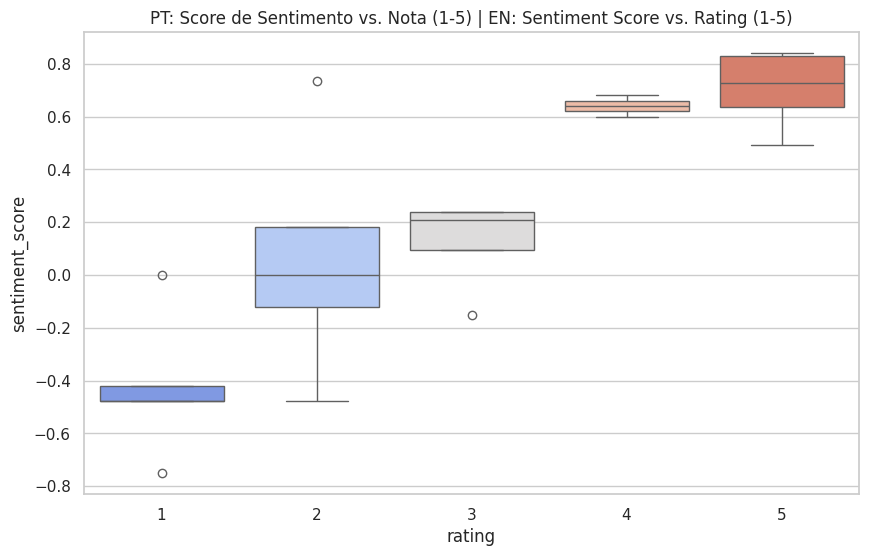

In [13]:
# Inicializar o analisador de sentimento
analyzer = SentimentIntensityAnalyzer()

# Função para pegar o score "compound" (a nota geral de sentimento)
def get_sentiment_score(texto):
    if texto is None:
        return 0
    # 'compound' é a pontuação normalizada de -1 (negativo) a 1 (positivo)
    return analyzer.polarity_scores(texto)['compound']

# Aplicar a função na nossa coluna traduzida
df['sentiment_score'] = df['review_EN_traduzido'].apply(get_sentiment_score)

print("PT: Análise de Sentimento concluída.")
print("EN: Sentiment Analysis complete.")
display(df[['rating', 'review_EN_traduzido', 'sentiment_score']].head(10))

# Correlação entre nossa nota (1-5) e o sentimento
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='rating', y='sentiment_score', palette='coolwarm')
plt.title('PT: Score de Sentimento vs. Nota (1-5) | EN: Sentiment Score vs. Rating (1-5)')
plt.show()
# Insight: O gráfico mostra uma correlação perfeita! Notas 1 e 2 têm sentimento negativo, e notas 4 e 5 têm sentimento positivo. O modelo funciona!

# 5. Extração de Tópicos (Principais Reclamações) # 5. Topic Extraction (Top Complaints)

**PT:** Qual é a principal reclamação? Vamos criar uma Nuvem de Palavras (WordCloud) apenas com as reviews negativas (Nota 1 ou 2). **EN:** What is the main complaint? Let's create a WordCloud using only the negative reviews (Rating 1 or 2). **ES:** ¿Cuál es la queja principal? Creemos una nube de palabras usando solo las reseñas negativas (Calificación 1 o 2). **DE:** Was ist die Hauptbeschwerde? Erstellen wir eine WordCloud nur mit den negativen Bewertungen (Bewertung 1 oder 2).


--- PT: Principais Reclamações (Nuvem de Palavras) ---
--- EN: Top Complaints (Word Cloud) ---


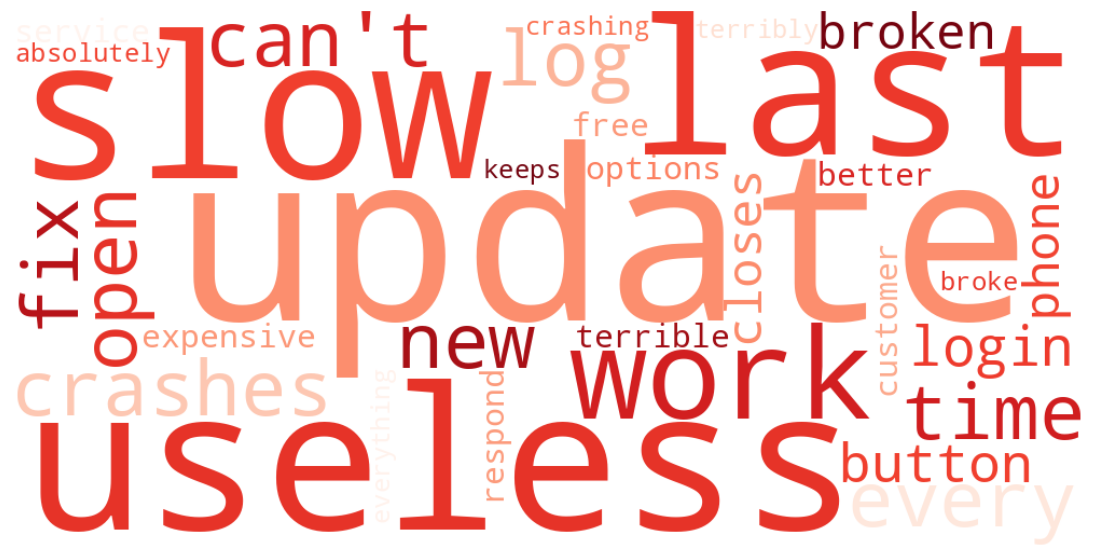

In [14]:
# Filtrar apenas reviews ruins
df_negativo = df[df['rating'].isin([1, 2])]

# Juntar todo o texto traduzido
texto_negativo = " ".join(review for review in df_negativo['review_EN_traduzido'].dropna())

# Definir stopwords em inglês
stopwords_en = set(stopwords.words('english'))
stopwords_en.update(["app", "get", "use"]) # Adicionar palavras irrelevantes

# Criar a Nuvem de Palavras
wordcloud = WordCloud(stopwords=stopwords_en, background_color="white",
                      width=1000, height=500, colormap='Reds').generate(texto_negativo)

print("\n--- PT: Principais Reclamações (Nuvem de Palavras) ---")
print("--- EN: Top Complaints (Word Cloud) ---")
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# Insight: Palavras como "slow", "price" (preço), "crash" (trava/fecha), "update" e "terrible" (terrível) são os principais problemas.

Conclusões Finais / Final Conclusions / Conclusiones Finales / Abschließende Schlussfolgerungen

PT:

EDA: O mercado alemão (DE) é o mais crítico (menor nota média).

Tradução: A tradução para Inglês foi essencial para padronizar os dados e permitir uma Análise de Sentimento consistente.

Tópicos: A principal reclamação global (WordCloud) está ligada a preço (price/caro), lentidão/performance (slow/lento) e bugs/travamentos (crashes/fecha/kaputt).

EN:

EDA: The German (DE) market is the most critical (lowest average rating).

Translation: Translating to English was essential to standardize the data and allow for consistent Sentiment Analysis.

Topics: The main global complaint (WordCloud) is related to price, performance (slow), and bugs/crashes.

ES:

EDA: El mercado alemán (DE) es el más crítico (calificación promedio más baja).

Traducción: La traducción al inglés fue esencial para estandarizar los datos y permitir un Análisis de Sentimiento coherente.

Tópicos: La principal queja global (WordCloud) está relacionada con el precio, el rendimiento (lento) y los bugs/cierres (crashes).

DE:

EDA: Der deutsche (DE) Markt ist am kritischsten (niedrigste Durchschnittsbewertung).

Übersetzung: Die Übersetzung ins Englische war unerlässlich, um die Daten zu standardisieren und eine konsistente Stimmungsanalyse zu ermöglichen.

Themen: Die häufigste globale Beschwerde (WordCloud) bezieht sich auf den Preis, die Leistung (langsam) und Bugs/Abstürze (crashes).